# Data exploration and preparation notebook
### TODO:

• Gather general statistics about the provided convictions time-series

• Identify any potential problems with data, filter outliers etc.

• Prepare a master index of stock symbols and retrieve corresponding price
data for each symbol (sources, e.g. Yahoo Finance or Google)

In [378]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import copy

In [379]:
data_raw = pd.read_csv("CONVICTIONLISTTOPN_BSLD-408.csv", header=None)
data_raw.head()

,0,1,2,3,4,5,6
0,10:01:54.481 77425 [77425-thread-2] INFO a.s....,2004-02-11,SU,SU,Energy Minerals,GN63J3-R,0.953727
1,10:01:54.481 77425 [77425-thread-2] INFO a.s....,2004-02-11,GGG,GGG,Producer Manufacturing,H5490W-R,0.952753
2,10:01:54.481 77425 [77425-thread-2] INFO a.s....,2004-02-11,WGR,WGR,Energy Minerals,V0622Q-R,0.947634
3,10:01:54.481 77425 [77425-thread-2] INFO a.s....,2004-02-11,CWT,CWT,Utilities,GSWXLY-R,0.934181
4,10:01:54.481 77425 [77425-thread-2] INFO a.s....,2004-02-11,BLL,BLL,Process Industries,VFT0VQ-R,0.922862


In [380]:
# Let's see the whole string from first column, first row
str(data_raw.iloc[0, 0])

'10:01:54.481 77425 [77425-thread-2] INFO  a.s.m.c.ConvictionImpl - CONVICTIONLISTTOPN'

There are 7 columns

0 - part of some logs, contains hour, some number, thread number, log type (INFO, ERROR, WARN etc.), some characters - check which parts vary accross rows

1 - date

2 - stock symbol?

3 - stock symbol?

4 - Branch of economy/business the company is doing

5 - Another stock symbol? Explore further

6 - score; Target variable


In [381]:
data = copy.deepcopy(data_raw)

## 0 column

In [382]:
# Check if there is any variability in this column apart from hour
set([x[12:] for x in list(data_raw[0].unique())])

{' 77425 [77425-thread-2] INFO  a.s.m.c.ConvictionImpl - CONVICTIONLISTTOPN'}

In [383]:
data[0] = data[0].str.slice(start=0, stop=12, step=1)
data.head()

,0,1,2,3,4,5,6
0,10:01:54.481,2004-02-11,SU,SU,Energy Minerals,GN63J3-R,0.953727
1,10:01:54.481,2004-02-11,GGG,GGG,Producer Manufacturing,H5490W-R,0.952753
2,10:01:54.481,2004-02-11,WGR,WGR,Energy Minerals,V0622Q-R,0.947634
3,10:01:54.481,2004-02-11,CWT,CWT,Utilities,GSWXLY-R,0.934181
4,10:01:54.481,2004-02-11,BLL,BLL,Process Industries,VFT0VQ-R,0.922862


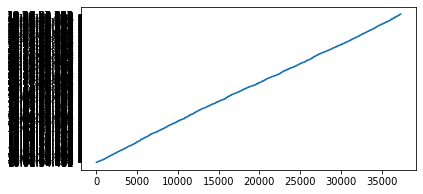

In [384]:
plt.plot(range(len(data)), data[0])
plt.show()

Not the prettiest plot - but it shows that the hours are probably just monotonically increasing. Let's check that to be sure

In [385]:
data[0].is_monotonic_increasing

True

The hours are monotically increasing or constant; indicates that those are probably just the hours when logs were pulled from the system and have nothing to do with the target variable. Shouldn't remain in the analysis, let's remove it

In [386]:
data = data.drop(0, axis=1)
data

,1,2,3,4,5,6
0,2004-02-11,SU,SU,Energy Minerals,GN63J3-R,0.953727
1,2004-02-11,GGG,GGG,Producer Manufacturing,H5490W-R,0.952753
2,2004-02-11,WGR,WGR,Energy Minerals,V0622Q-R,0.947634
3,2004-02-11,CWT,CWT,Utilities,GSWXLY-R,0.934181
4,2004-02-11,BLL,BLL,Process Industries,VFT0VQ-R,0.922862
...,...,...,...,...,...,...
37355,2022-02-09,PEP,PEP,Consumer Non-Durables,PPCTFP-R,0.701507
37356,2022-02-09,SSNC,SSNC,Technology Services,G92RX2-R,0.701123
37357,2022-02-09,GEF,GEF,Process Industries,MPX0N4-R,0.697954
37358,2022-02-09,DPZ,DPZ,Consumer Services,F05QG0-R,0.697741


## 1 column

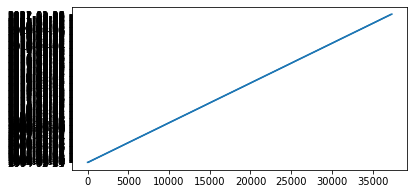

In [387]:
plt.plot(range(len(data)), data[1])
plt.show()

In [388]:
data[1].is_monotonic_increasing

True

Same as above, but those are dates! Let's check if each day is present or is it weekly or monthly or what. Later split into day, month, year and keep those columns, discard the original date as a whole.

In [389]:
dates = pd.DataFrame(copy.deepcopy(data[1]).unique())
dates["date_copy"] = dates[0].shift(1)#.drop(0, axis=0)
dates = dates.apply(pd.to_datetime)
dates["dates_diff"] = (dates[0] - dates["date_copy"]).dt.days
dates.groupby("dates_diff").count()[0]

dates_diff
14.0    461
21.0      3
28.0      2
Name: 0, dtype: int64

In [390]:
dates[dates["dates_diff"]>14]

,0,date_copy,dates_diff
89,2007-07-18,2007-06-27,21.0
219,2012-07-18,2012-06-27,21.0
257,2014-01-15,2013-12-18,28.0
374,2018-07-18,2018-06-27,21.0
412,2020-01-15,2019-12-18,28.0


Mostly the observations are done bi-weekly, sometimes tri-weekly or quad-weekly. No way to easily remove the tri and quad-weekly observations as it would create even bigger data gaps. Will leave it as it is

In [391]:
data["year"] = data[1].str.slice(start=0, stop=4)
data["month"] = data[1].str.slice(start=5, stop=7)
data["day"] = data[1].str.slice(start=8, stop=10)
data = data.rename({1:"date"}, axis=1)
data.head()

,date,2,3,4,5,6,year,month,day
0,2004-02-11,SU,SU,Energy Minerals,GN63J3-R,0.953727,2004,02,11
1,2004-02-11,GGG,GGG,Producer Manufacturing,H5490W-R,0.952753,2004,02,11
2,2004-02-11,WGR,WGR,Energy Minerals,V0622Q-R,0.947634,2004,02,11
3,2004-02-11,CWT,CWT,Utilities,GSWXLY-R,0.934181,2004,02,11
4,2004-02-11,BLL,BLL,Process Industries,VFT0VQ-R,0.922862,2004,02,11


Let's do some plots dividing the data based on day, month and year

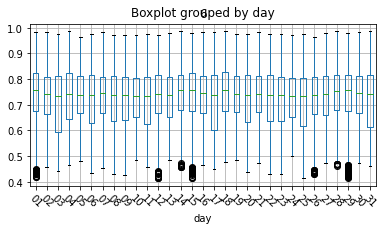

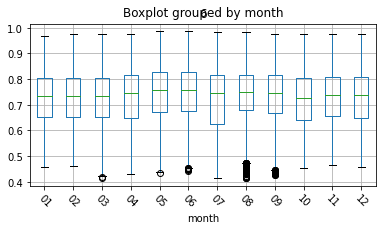

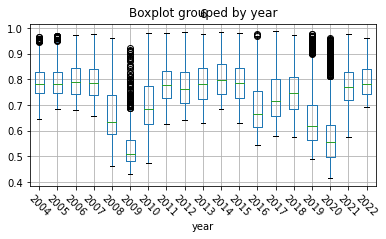

In [392]:
data.boxplot(column=6, by="day")
plt.xticks(rotation = -45)
plt.show()
data.boxplot(column=6, by="month")
plt.xticks(rotation = -45)
plt.show()
data.boxplot(column=6, by="year")
plt.xticks(rotation = -45)
plt.show()

As is to be expected - month and day don't cause a big variation in the data, year does!

Years 2009, 2019 and 2020 have many outliers and seem atypical in the sense that their distribution is lower than other years.

One year before and after 2009 - 2008 and 2010 are also slightly lower than most, this is understandable as there was a financial crysis 2008-2010.
Same goes for 2019 and 2020 - financial crysis connected with the COVID-19 pandemic.

2016 is another year of low convictions, it was a year of mini-recession.

## 2&3 column

I think this is a replicated column, let's check:

In [393]:
len(data) == len(data[data[2]==data[3]])

True

Yes, let's drop column 3 and rename column 2 to "symbol"

In [394]:
data = data.drop(3, axis=1)
data = data.rename({2: "symbol"}, axis=1)
data

,date,symbol,4,5,6,year,month,day
0,2004-02-11,SU,Energy Minerals,GN63J3-R,0.953727,2004,02,11
1,2004-02-11,GGG,Producer Manufacturing,H5490W-R,0.952753,2004,02,11
2,2004-02-11,WGR,Energy Minerals,V0622Q-R,0.947634,2004,02,11
3,2004-02-11,CWT,Utilities,GSWXLY-R,0.934181,2004,02,11
4,2004-02-11,BLL,Process Industries,VFT0VQ-R,0.922862,2004,02,11
...,...,...,...,...,...,...,...,...
37355,2022-02-09,PEP,Consumer Non-Durables,PPCTFP-R,0.701507,2022,02,09
37356,2022-02-09,SSNC,Technology Services,G92RX2-R,0.701123,2022,02,09
37357,2022-02-09,GEF,Process Industries,MPX0N4-R,0.697954,2022,02,09
37358,2022-02-09,DPZ,Consumer Services,F05QG0-R,0.697741,2022,02,09


## 4 column

In [395]:
print(len(data[4].unique()))
list(data[4].unique())

20


['Energy Minerals',
 'Producer Manufacturing',
 'Utilities',
 'Process Industries',
 'Consumer Services',
 'Transportation',
 'Retail Trade',
 'Finance',
 'Health Technology',
 'Miscellaneous',
 'Non-Energy Minerals',
 'Distribution Services',
 'Consumer Non-Durables',
 'Commercial Services',
 'Technology Services',
 'Consumer Durables',
 'Health Services',
 'Electronic Technology',
 'Industrial Services',
 'Communications']

There are 20 distinct branches, let's change column name and see some conditional probability distributions again using boxplots and violing plots as well

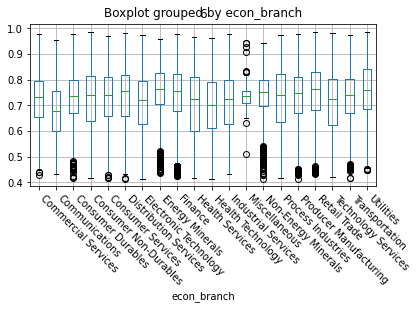

c:\Users\Jacek\VSCodeProjects\ML_finance\.venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


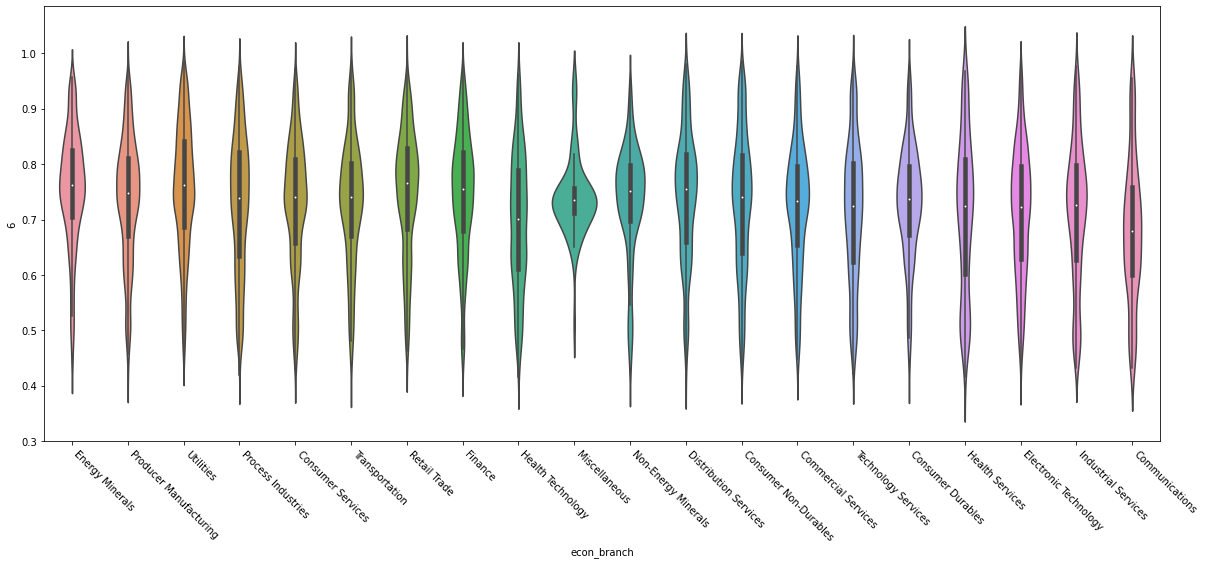

In [396]:
data = data.rename({4: "econ_branch"}, axis=1)

data.boxplot(column=6, by="econ_branch")
plt.rcParams["figure.figsize"] = (20,8)
plt.xticks(rotation = -45, ha='left')
plt.show()

fig, ax = plt.subplots(figsize=(20,8))
ax = sns.violinplot(data["econ_branch"], data[6])
plt.xticks(rotation = -45, ha='left')
plt.show()

Overall no huge differences between different branches of the economy, Miscellaneous category seems like the biggest outlier, seems to be a small subdataset, let's explore further and check if we want to remove those observations

In [397]:
misc = data[data["econ_branch"]=="Miscellaneous"]
misc.head()

,date,symbol,econ_branch,5,6,year,month,day
15,2004-02-11,HGTXU,Miscellaneous,MMMNG3-R,0.834775,2004,02,11
45,2004-02-11,SJT,Miscellaneous,DLRTBS-R,0.738945,2004,02,11
99,2004-02-25,HGTXU,Miscellaneous,MMMNG3-R,0.811405,2004,02,25
125,2004-02-25,SJT,Miscellaneous,DLRTBS-R,0.733261,2004,02,25
212,2004-03-10,HGTXU,Miscellaneous,MMMNG3-R,0.736554,2004,03,10


In [398]:
set(misc["symbol"])

{'BPT', 'CGIFF', 'HGTXU', 'PBT', 'SJT', 'TPL'}

Only 6 companies, seems like a good idea to remove those as they are hard to classify and not your typical companies, they could confuse the models we're going to build

In [399]:
data = data[data["econ_branch"]!="Miscellaneous"]
data.head()

,date,symbol,econ_branch,5,6,year,month,day
0,2004-02-11,SU,Energy Minerals,GN63J3-R,0.953727,2004,02,11
1,2004-02-11,GGG,Producer Manufacturing,H5490W-R,0.952753,2004,02,11
2,2004-02-11,WGR,Energy Minerals,V0622Q-R,0.947634,2004,02,11
3,2004-02-11,CWT,Utilities,GSWXLY-R,0.934181,2004,02,11
4,2004-02-11,BLL,Process Industries,VFT0VQ-R,0.922862,2004,02,11


## 5 column

First assumption - column symbol and column 5 mean the same but are different, let's check if for each symbol there is only 1 corresponding value from column 5

In [400]:
# Let's collect all of the possible values of column 5 grouped by symbol
unique_5_for_symbol =  data[["symbol", 5]].groupby("symbol")[5].apply(set)
# Size of the set of all values of column 5 for a given symbol (we hope all are 1)
size_of_unique_5_for_symbol = unique_5_for_symbol.apply(len)
# Check if all length are equal to 1
size_of_unique_5_for_symbol.apply(lambda x: x==1).all()

True

Yes, column 5 can be mapped 1-1 to column symbol, let's get rid of it

In [401]:
data = data.drop(5, axis=1)
data.head()

,date,symbol,econ_branch,6,year,month,day
0,2004-02-11,SU,Energy Minerals,0.953727,2004,02,11
1,2004-02-11,GGG,Producer Manufacturing,0.952753,2004,02,11
2,2004-02-11,WGR,Energy Minerals,0.947634,2004,02,11
3,2004-02-11,CWT,Utilities,0.934181,2004,02,11
4,2004-02-11,BLL,Process Industries,0.922862,2004,02,11


## 6 column

We're sure we don't want to remove this column but let's explore it

In [402]:
target = copy.deepcopy(data[6])
target

0        0.953727
1        0.952753
2        0.947634
3        0.934181
4        0.922862
           ...   
37355    0.701507
37356    0.701123
37357    0.697954
37358    0.697741
37359    0.695644
Name: 6, Length: 37295, dtype: float64

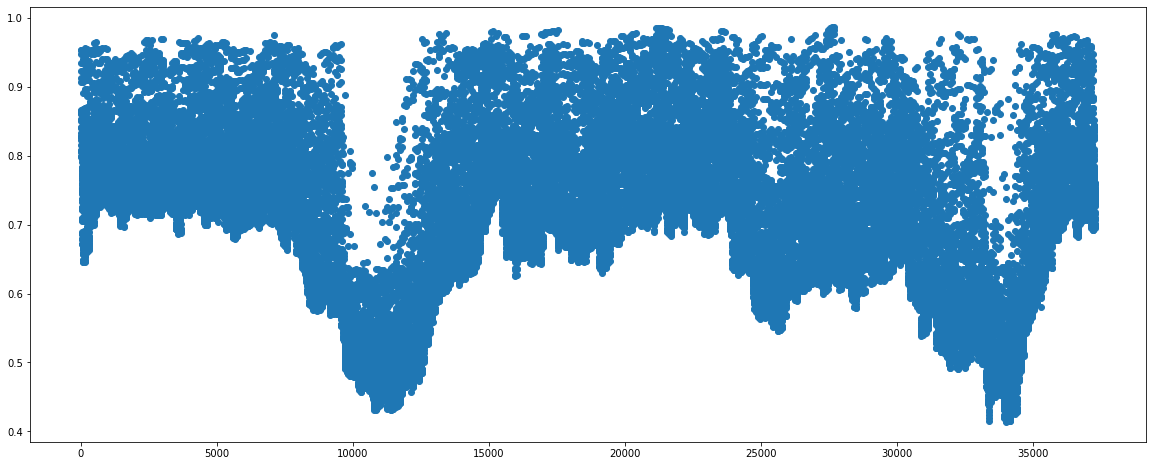

In [403]:
plt.scatter(range(len(target)), target)

What we see is similar to the boxplot splitting by year, convictions for the most part lie between 0.65 and 1, with years 2007-2009 and 2019-2020 being significantly lower, falling into range of between 0.4 and 0.65. 2016-2018 is between 0.6 and 0.9, but the densest closer to 0.6

Thinking ahead here there is a decision to be made: 

a) Split the data into two subsets - regular economic situation, so years 2004-2006, 2010-2018 and 2021-2022; and recession subset: 2007-2009 and 2019-2020. Train two different models, use the proper one depending on the judgement if the economy is healthy or in recession

b) Leave the dataset as is and train the model on whole dataset

For now I'd reccomend leaving the dataset as is, but let's keep option a) in mind for the future

In [404]:
data = data.rename({6: "score"}, axis=1)
data.head()

,date,symbol,econ_branch,score,year,month,day
0,2004-02-11,SU,Energy Minerals,0.953727,2004,02,11
1,2004-02-11,GGG,Producer Manufacturing,0.952753,2004,02,11
2,2004-02-11,WGR,Energy Minerals,0.947634,2004,02,11
3,2004-02-11,CWT,Utilities,0.934181,2004,02,11
4,2004-02-11,BLL,Process Industries,0.922862,2004,02,11


## In the end we have the following dataset:

In [405]:
data

,date,symbol,econ_branch,score,year,month,day
0,2004-02-11,SU,Energy Minerals,0.953727,2004,02,11
1,2004-02-11,GGG,Producer Manufacturing,0.952753,2004,02,11
2,2004-02-11,WGR,Energy Minerals,0.947634,2004,02,11
3,2004-02-11,CWT,Utilities,0.934181,2004,02,11
4,2004-02-11,BLL,Process Industries,0.922862,2004,02,11
...,...,...,...,...,...,...,...
37355,2022-02-09,PEP,Consumer Non-Durables,0.701507,2022,02,09
37356,2022-02-09,SSNC,Technology Services,0.701123,2022,02,09
37357,2022-02-09,GEF,Process Industries,0.697954,2022,02,09
37358,2022-02-09,DPZ,Consumer Services,0.697741,2022,02,09


Columns detail:

symbol - symbol of the company

econ_branch - branch of the economy that the company is operating under

score - conviction score (target variable)

date, year, month, day - date of the observed conviction

## Further exploration

Let's finally see how conviction scores aggregated on the level of a company look like

5 random companies

5 companies with lowest scores

5 with highest scores

In [406]:
# companies = list(data["symbol"].unique())
companies = data.groupby("symbol").mean().sort_values(by="score")
random_companies = random.choices(companies.index, k=5)
best_companies = list(companies.tail().index)
worst_companies = list(companies.head().index)
print(random_companies, best_companies, worst_companies)

['CLGX', 'CIM', 'TFCFA', 'RSCR', 'WOR'] ['BDG.A', 'GOOG', 'WGR', 'AVGO', 'CDX.XX1'] ['AMIVF', 'IONS', 'HOTT', 'ABM', 'JBT']


In [407]:

data["date"] = data["date"].apply(pd.to_datetime)
data

,date,symbol,econ_branch,score,year,month,day
0,2004-02-11,SU,Energy Minerals,0.953727,2004,02,11
1,2004-02-11,GGG,Producer Manufacturing,0.952753,2004,02,11
2,2004-02-11,WGR,Energy Minerals,0.947634,2004,02,11
3,2004-02-11,CWT,Utilities,0.934181,2004,02,11
4,2004-02-11,BLL,Process Industries,0.922862,2004,02,11
...,...,...,...,...,...,...,...
37355,2022-02-09,PEP,Consumer Non-Durables,0.701507,2022,02,09
37356,2022-02-09,SSNC,Technology Services,0.701123,2022,02,09
37357,2022-02-09,GEF,Process Industries,0.697954,2022,02,09
37358,2022-02-09,DPZ,Consumer Services,0.697741,2022,02,09


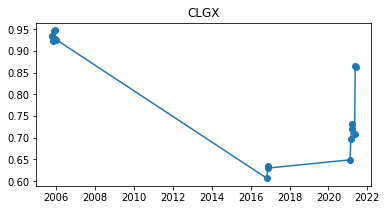

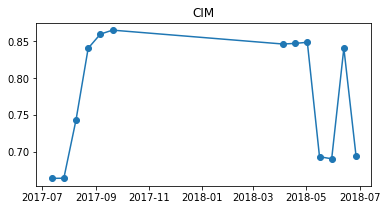

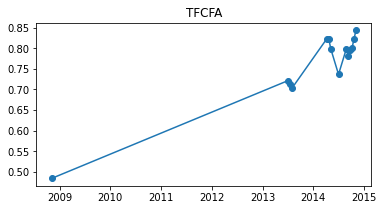

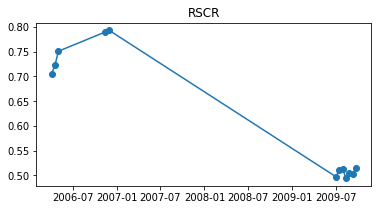

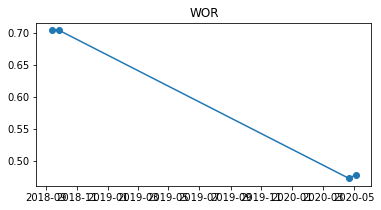

In [408]:
plt.rcParams["figure.figsize"] = (6,3)
for company in random_companies:
    cmpny_data = data[data["symbol"]==company]
    plt.scatter(cmpny_data["date"], cmpny_data["score"])
    plt.plot(cmpny_data["date"], cmpny_data["score"])
    plt.title(company)
    plt.show()

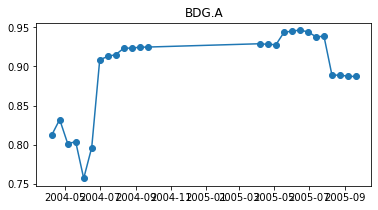

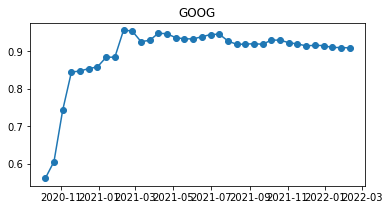

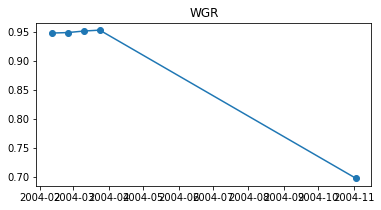

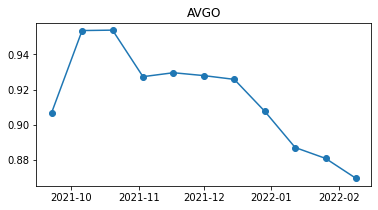

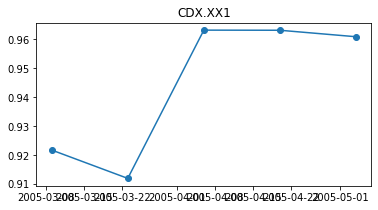

In [409]:
for company in best_companies:
    cmpny_data = data[data["symbol"]==company]
    plt.scatter(cmpny_data["date"], cmpny_data["score"])
    plt.plot(cmpny_data["date"], cmpny_data["score"])
    plt.title(company)
    plt.show()

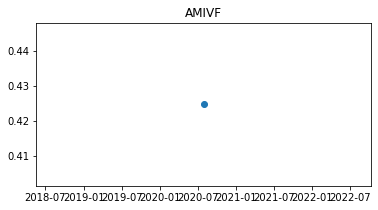

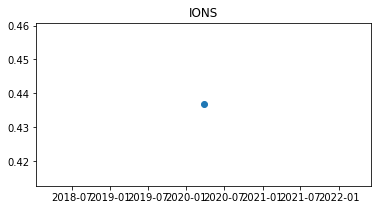

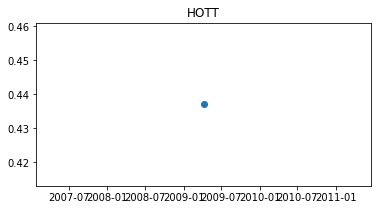

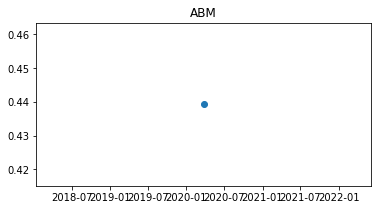

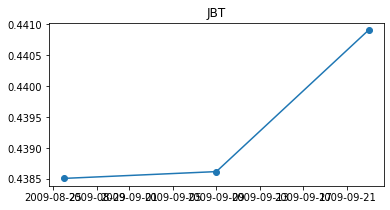

In [410]:
for company in worst_companies:
    cmpny_data = data[data["symbol"]==company]
    plt.scatter(cmpny_data["date"], cmpny_data["score"])
    plt.plot(cmpny_data["date"], cmpny_data["score"])
    plt.title(company)
    plt.show()

The "worst" performing are just single data points. Let's remove <2 item companies. 

In [432]:
observations_per_company = data.groupby("symbol").count()["score"].sort_values()
observations_per_company = observations_per_company[observations_per_company>1]
data_horizons = observations_per_company.value_counts().sort_index()
data_horizons

2      110
3      100
4      102
5       76
6       75
      ... 
117      1
119      2
122      1
138      1
170      1
Name: score, Length: 104, dtype: int64

In [447]:
init_data_count = len(data)
print(init_data_count)
data = data[data["symbol"].isin(observations_per_company.index)]
print(len(data))
print("Difference after removal: ", len(data)-init_data_count)


37214
37214
Difference after removal:  0


Removed only 81 observations, which would have been useless anyway due to the data being a time series

How many companies have good enough data for a monthly, quarterly, semi-annual and annual investment horizons? 

In [449]:
data_horizons>=2

2       True
3       True
4       True
5       True
6       True
       ...  
117    False
119     True
122    False
138    False
170    False
Name: score, Length: 104, dtype: bool

In [451]:
print("monthly: ", sum(data_horizons[data_horizons>=2]))
print("quarterly: ", sum(data_horizons[data_horizons>=6]))
print("semi-annually: ", sum(data_horizons[data_horizons>=13]))
print("annualy: ", sum(data_horizons[data_horizons>=26]))

monthly:  1729
quarterly:  1640
semi-annually:  1460
annualy:  1213


There is some long-term data in the dataset. Should be enough to justify trying to make some predictions even a year ahead.

# Joining with prices data